In [60]:
library(rhdf5)
library(SingleCellExperiment)
library(Matrix)
library(scater)

Make_unique <- function(arr) {
  dep_arr <- list()
  dep_idx <- which(duplicated(arr))
  for (idx in dep_idx) {
    item <- arr[idx]
    if (!(item %in% attr(dep_arr, "names"))) {
      dep_arr[item] <- 1
    }
    count <- dep_arr[[item]]
    arr[idx] <- paste0(arr[idx], ".", count)
    dep_arr[[item]] <- dep_arr[[item]] + 1
  }
  return(arr)
}

Load_h5adsc_to_SCE <- function(scpath, raw = TRUE) {
  scmat <- h5read(scpath, "/")
  if (("Raw" %in% attr(scmat$layers, "names")) && raw) {
    cat("** Using raw data...\n")
    if (class(scmat$layers$Raw)[[1]] == "list") {
      cat("** Raw data is a sparse matrix...\n")
      dat <- sparseMatrix(
        i = scmat$layers$Raw$indices[] + 1,
        p = scmat$layers$Raw$indptr[],
        x = as.numeric(scmat$layers$Raw$data[]),
        repr = "C"
      )
    } else {
      cat("** Raw data is a dense matrix...\n")
      dat <- as(scmat$layers$Raw, "dgCMatrix")
    }
    h5ad.var <- scmat$var
  } else {
    cat("** Using processed data...\n")
    X <- scmat$X
    dat <- sparseMatrix(
      i = X$indices[] + 1,
      p = X$indptr[],
      x = as.numeric(X$data[]),
      repr = "C"
    )
    h5ad.var <- scmat$var
  }
  cat("** Core data loaded...\n")
  # generate factors using categories
  var <- list()
  if ("__categories" %in% attr(h5ad.var, "names")) { # old anndata
    for (name in attr(h5ad.var[["__categories"]], "names")) {
      if (length(h5ad.var[[name]]) >= length(h5ad.var[["__categories"]][[name]])) {
        var[[name]] <- factor(h5ad.var[[name]], labels = h5ad.var[["__categories"]][[name]])
      }
    }
  } else {
    for (name in attr(h5ad.var, "names")) {
      if (name != "_index") {
        if (class(var[[name]]) == "list") {
          var[[name]] <- factor(h5ad.var[[name]]$codes,
            labels = h5ad.var[[name]]$categories
          )
        } else {
          var[[name]] <- h5ad.var[[name]]
        }
      } else {
        var[[name]] <- h5ad.var[[name]]
      }
    }
  }
  cat("** Var loaded...\n")
  h5ad.obs <- scmat$obs
  obs <- list()
  if ("__categories" %in% attr(h5ad.obs, "names")) { # old anndata
    for (name in attr(h5ad.obs[["__categories"]], "names")) {
      if (length(h5ad.obs[[name]]) >= length(h5ad.obs[["__categories"]][[name]])) {
        obs[[name]] <- factor(h5ad.obs[[name]], labels = h5ad.obs[["__categories"]][[name]])
      }
    }
  } else { # new anndata
    for (name in attr(h5ad.obs, "names")) {
      if (name != "_index") {
        if (class(h5ad.obs[[name]]) == "list") {
          obs[[name]] <- factor(h5ad.obs[[name]]$codes,
            labels = h5ad.obs[[name]]$categories
          )
        } else {
          obs[[name]] <- h5ad.obs[[name]]
        }
      } else {
        obs[[name]] <- h5ad.obs[[name]]
      }
    }
  }
  # some datasets uses barcodes instead of `_index`
  if (!("_index" %in% attr(h5ad.obs, "names"))) {
    obs$`_index` <- obs$`barcodes`
  }
  obs$`_index` <- Make_unique(obs$`_index`)
  obs_use <- data.frame(
    annotation = obs$annotation,
    batch = obs$batch,
    age = obs$age,
    IHC = obs$IHC,
    cnv_status = obs$cnv_status,
    cnv_score = obs$cnv_score,
    row.names = as.character(obs$`_index`)
  )
  cat("** Obs loaded...\n")
  dims <- c(length(h5ad.var[["_index"]]), length(obs$`_index`))
  dat@Dim <- dims
  dat@Dimnames <- list(
    as.character(h5ad.var[["_index"]]),
    as.character(obs$`_index`)
  )
  cat("** Dims loaded...\n")

  sce <- SingleCellExperiment(
    assays = list(counts = dat),
    rowData = DataFrame(data.frame(var[['_index']])),
    colData = DataFrame(data.frame(obs_use))
  )
  cat("** SCE constructed...\n")

  umap <- as.data.frame(t(scmat$obsm$X_umap))
  colnames(umap) <- c('UMAP-1', 'UMAP-2')
  rownames(umap) <- colnames(sce)
  reducedDim(sce, 'UMAP', withDimnames=TRUE) <- umap
  cat("** UMAP loaded...\n")
  return(sce)
}

In [28]:
scmat <- h5read("adata-epi-concat-12.17.h5ad", "/")

In [61]:
length(SimpleList(UMAP = umap))

[1] 2

In [62]:
tempdir()

[1] "/tmp/RtmpRezQgL"

In [45]:
reducedDim(sce, 'UMAP', withDimnames=TRUE) <- umap

In [3]:
sce <- Load_h5adsc_to_SCE("adata-epi-concat-12.17.h5ad", raw = TRUE)

**Using processed data...
**Core data loaded...
**Var loaded...
**Obs loaded...
**Dims loaded...
**SCE constructed...


In [5]:
library(Seurat)
library(SeuratObject)
seu <- SeuratObject::as.Seurat(x = sce, counts = "counts", data = "counts")

In [48]:
sce <- slingshot(sce, 
                 clusterLabels = 'annotation',  # 选择colData中细胞注释的列名
                 reducedDim = 'UMAP',  
                )    

In [49]:
colnames(colData(sce))

[1] "annotation"        "batch"             "slingshot"        
[4] "slingPseudotime_1" "slingPseudotime_2"

In [51]:
library(RColorBrewer)

[1] "#B21746"   "#9E0142"   "#B21746"   "#A30643"   "#B71C47"   "#B21746"  
    [7] "#B21746"   "#A80C44"   "#D0EC9C"   "#B71C47"   "#9E0142"   "#D5EE9B"  
   [13] "#A30643"   "#B21746"   "#A30643"   "#9E0142"   "#AD1145"   "#9E0142"  
   [19] "#9E0142"   "#AD1145"   "#A30643"   "#A4DAA4"   "#9E0142"   "#9E0142"  
   [25] "#A80C44"   "lightgrey" "#57B2AB"   "#9E0142"   "#9E0142"   "#A30643"  
   [31] "#B0DFA2"   "#D0EC9C"   "#A30643"   "#B71C47"   "#F46D43"   "#A80C44"  
   [37] "#A30643"   "#A30643"   "#D0EC9C"   "#AD1145"   "#B21746"   "#9E0142"  
   [43] "#A80C44"   "#A80C44"   "#9E0142"   "#B21746"   "#A30643"   "#9E0142"  
   [49] "#B5E1A1"   "#AD1145"   "lightgrey" "#9E0142"   "#A30643"   "#9E0142"  
   [55] "#9E0142"   "#91D3A4"   "#B21746"   "#B21746"   "#B21746"   "#F46D43"  
   [61] "#AD1145"   "#9E0142"   "#A30643"   "#AD1145"   "#AD1145"   "#A30643"  
   [67] "#A80C44"   "#A30643"   "#F46D43"   "#AD1145"   "#F46D43"   "#9E0142"  
   [73] "#A80C44"   "#B21746"   "#9E0142"   "#A30643"   "lightgrey" "#D0EC9C"  
   [79] "#D0EC9C"   "#A30643"   "#DBF09A"   "#A30643"   "lightgrey" "#A30643"  
   [85] "#A30643"   "#A80C44"   "#A30643"   "#AD1145"   "#B21746"   "#A80C44"  
   [91] "#F47245"   "#A30643"   "#A30643"   "#A80C44"   "#A80C44"   "#9E0142"  
   [97] "#A30643"   "#9E0142"   "#A80C44"   "#B71C47"   "#A30643"   "#B21746"  
  [103] "#9E0142"   "#A30643"   "#91D3A4"   "#B71C47"   "#A80C44"   "#D0EC9C"  
  [109] "#AD1145"   "#F46D43"   "#A30643"   "#9E0142"   "#D0EC9C"   "#A30643"  
  [115] "#A30643"   "lightgrey" "#AD1145"   "#B21746"   "#F16844"   "#B21746"  
  [121] "#A30643"   "#A80C44"   "#A30643"   "#B21746"   "#A30643"   "#61BCA7"  
  [127] "#AD1145"   "#B21746"   "#9E0142"   "#D0EC9C"   "#B71C47"   "#B21746"  
  [133] "#A80C44"   "lightgrey" "#B21746"   "#A80C44"   "#AD1145"   "#B71C47"  
  [139] "#A30643"   "#A80C44"   "#A80C44"   "#A30643"   "#D0EC9C"   "#B21746"  
  [145] "#A30643"   "#A4DAA4"   "#A30643"   "#A30643"   "#9E0142"   "#B21746"  
  [151] "#9E0142"   "#A80C44"   "#D0EC9C"   "#AD1145"   "#B21746"   "#B21746"  
  [157] "#AD1145"   "#AADCA4"   "#A80C44"   "#9E0142"   "#A30643"   "#A30643"  
  [163] "#AD1145"   "#B21746"   "#A30643"   "#9E0142"   "#A30643"   "#AD1145"  
  [169] "#A80C44"   "#B21746"   "lightgrey" "#B71C47"   "#D5EE9B"   "#B71C47"  
  [175] "#9ED8A4"   "#AD1145"   "#A80C44"   "#D0EC9C"   "#A30643"   "#B21746"  
  [181] "#A80C44"   "#98D5A4"   "#AD1145"   "#A30643"   "#9E0142"   "#9E0142"  
  [187] "#A30643"   "#A30643"   "#9E0142"   "#B0DFA2"   "#A80C44"   "#9E0142"  
  [193] "#AD1145"   "lightgrey" "#A80C44"   "#AD1145"   "#A80C44"   "#E85B47"  
  [199] "lightgrey" "#A30643"   "#A30643"   "#A30643"   "#A30643"   "#A30643"  
  [205] "#A80C44"   "#65C1A5"   "#A30643"   "#9E0142"   "#AD1145"   "#A30643"  
  [211] "#A80C44"   "#A80C44"   "#B21746"   "lightgrey" "#A80C44"   "#A80C44"  
  [217] "#9E0142"   "#9E0142"   "#B21746"   "#9E0142"   "#AD1145"   "#B71C47"  
  [223] "#B21746"   "#D0EC9C"   "#A80C44"   "#AD1145"   "#9E0142"   "#B21746"  
  [229] "#A30643"   "#A30643"   "#A30643"   "#AD1145"   "#A30643"   "#57B2AB"  
  [235] "#AADCA4"   "#AD1145"   "#A80C44"   "#A80C44"   "#B21746"   "#A30643"  
  [241] "#A30643"   "#9E0142"   "#9E0142"   "#B21746"   "#AD1145"   "#B21746"  
  [247] "#A80C44"   "#AADCA4"   "#A30643"   "#AD1145"   "#9E0142"   "#AD1145"  
  [253] "#A80C44"   "#B21746"   "#AD1145"   "lightgrey" "#A30643"   "#A30643"  
  [259] "#AD1145"   "#A30643"   "lightgrey" "#9E0142"   "#AD1145"   "#B21746"  
  [265] "#B21746"   "#A80C44"   "#B21746"   "#A80C44"   "#A80C44"   "#A30643"  
  [271] "#AD1145"   "#A30643"   "#AD1145"   "#AD1145"   "#B21746"   "#AD1145"  
  [277] "#F46D43"   "#9E0142"   "#A80C44"   "#AD1145"   "#9E0142"   "#A80C44"  
  [283] "#A30643"   "#B71C47"   "#B21746"   "#A30643"   "#A80C44"   "#9E0142"  
  [289] "lightgrey" "#9E0142"   "#AD1145"   "#9E0142"   "#DBF09A"   "#A30643"  
  [295] "lightgrey" "#A30643"   "#A80C44"   "#F47245"   "#A30643"   "#A80C44"  
  [3

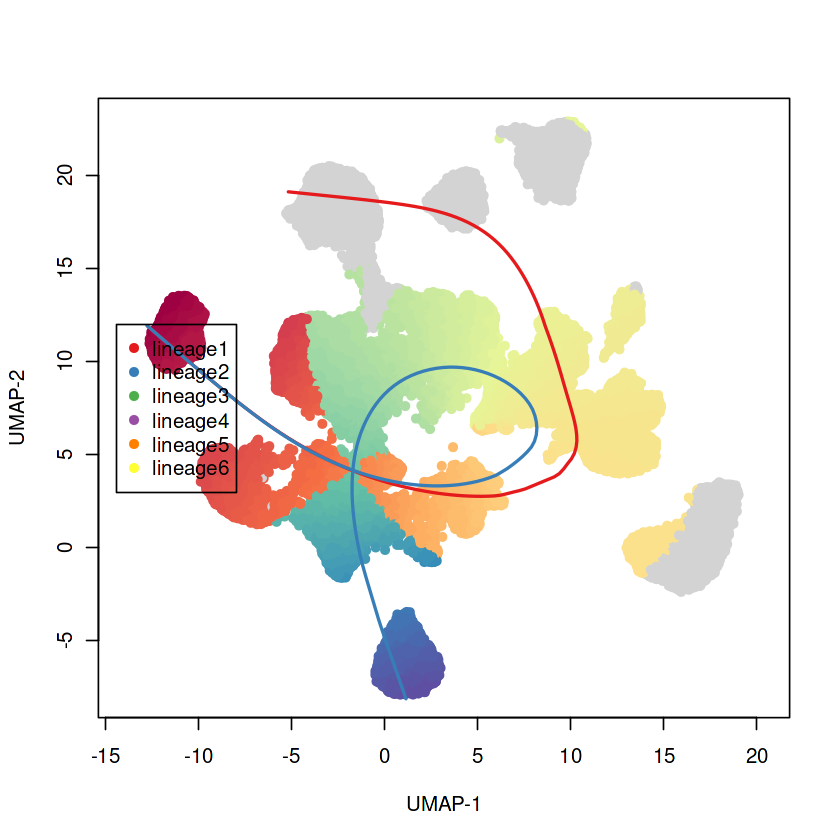

In [52]:
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100) # 我们把这些颜色变成100个梯度，模拟渐变色
plotcol <- colors[cut(sce$slingPseudotime_2, breaks=100)] # 这里我们用cut函数把 lineage2 分割成100个区间，同一区间的细胞给与同一个颜色
plotcol[is.na(plotcol)] <- "lightgrey" # 不属于 lineage3 的点为NA，我们把他们变成灰色
plotcol
sce@colData$plotcol<-plotcol
plot(reducedDims(sce)$UMAP, col = plotcol, pch=16, asp = 1)
lines(SlingshotDataSet(sce), lwd=2, col=brewer.pal(9,"Set1"))
legend("right",
       legend = paste0("lineage",1:6),
       col = unique(brewer.pal(6,"Set1")),
       inset=0.8,
       pch = 16)


In [4]:
library(monocle3)


Attaching package: ‘monocle3’


The following objects are masked from ‘package:Biobase’:

    exprs, fData, fData<-, pData, pData<-




In [5]:
gene_metadata <- as.data.frame(rownames(sce))
rownames(gene_metadata) <- rownames(sce)
colnames(gene_metadata) <- c("gene_short_name")
gene_metadata

,gene_short_name
,<chr>
TNFRSF4,TNFRSF4
TNFRSF18,TNFRSF18
ATAD3B,ATAD3B
PRDM16,PRDM16
ACAP3,ACAP3
PUSL1,PUSL1
PEX10,PEX10
CPTP,CPTP
SKI,SKI


In [6]:
cds <- new_cell_data_set(expression_data = sce@assays@data$counts, 
                         cell_metadata = as.data.frame(sce@colData),
                         gene_metadata = gene_metadata)

No preprocess_method specified, using preprocess_method = 'PCA'

No trajectory to plot. Has learn_graph() been called yet?



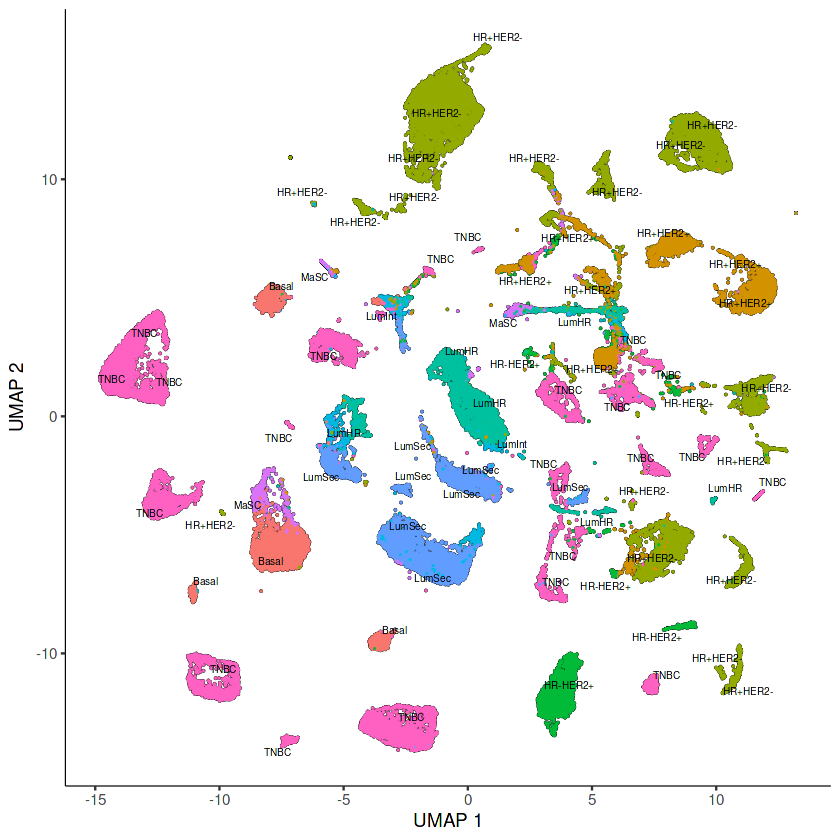

In [7]:
## Step 1: Normalize and pre-process the data
cds <- preprocess_cds(cds, num_dim = 15)

## Step 3: Reduce the dimensions using UMAP
cds <- reduce_dimension(cds)

## Step 4: Cluster the cells
cds <- cluster_cells(cds)

# ## Step 5: Learn a graph
# cds <- learn_graph(cds)

plot_cells(cds, color_cells_by="annotation")

No trajectory to plot. Has learn_graph() been called yet?



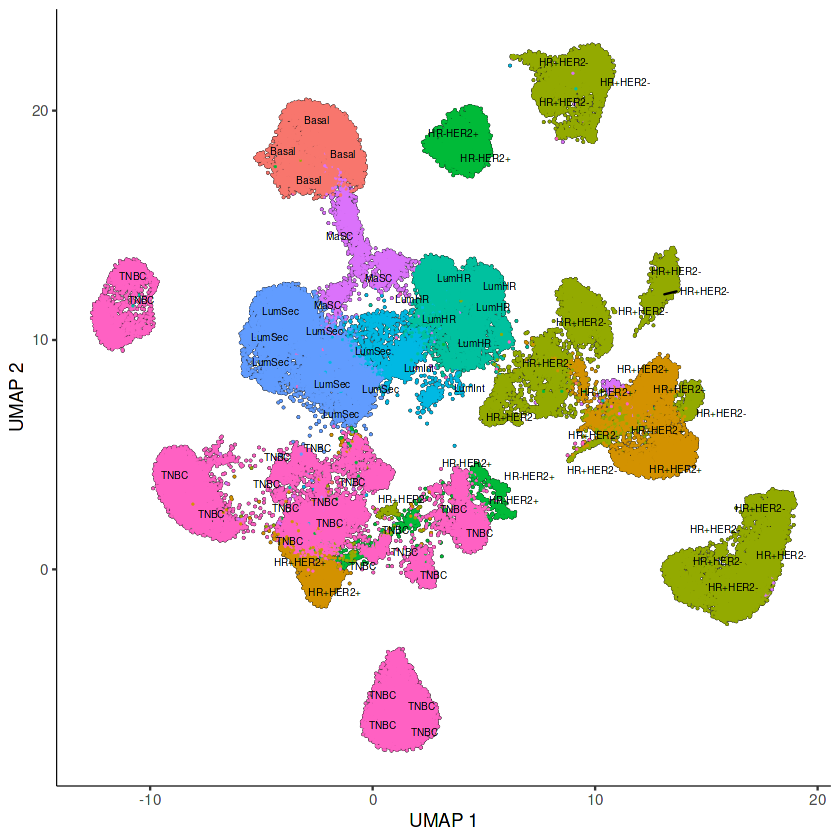

In [57]:
plot_cells(cds, color_cells_by="annotation")

In [58]:
cds <- learn_graph(cds)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

Warning message in cluster_cells_make_graph(data = data, weight = weight, cell_names = cell_names, :
“The nearest neighbors includes the point itself, k must be smaller than
the total number of points - 1 (all other points) - 1 (itself)! Total number of points is 26”


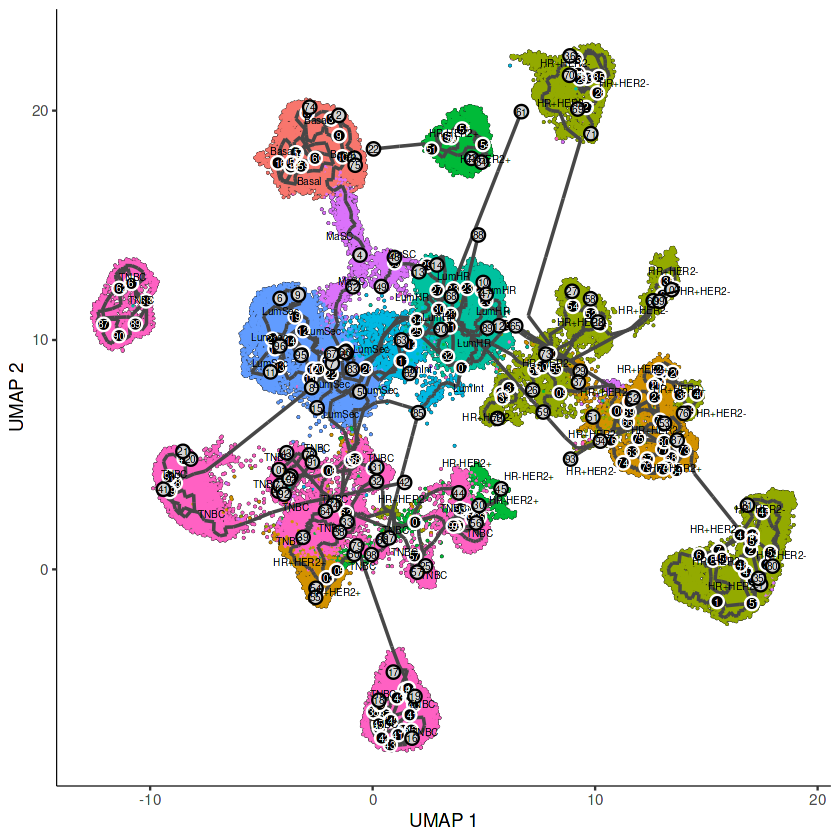

In [59]:
plot_cells(cds, color_cells_by="annotation")

In [4]:
library(monocle)

Loading required package: VGAM

Loading required package: splines

Loading required package: DDRTree

Loading required package: irlba



In [5]:
pd <- new("AnnotatedDataFrame", data = as.data.frame(sce@colData))
fd <- new("AnnotatedDataFrame", data = gene_metadata)
HSMM <- newCellDataSet(sce@assays@data$counts, 
                       phenoData = pd, 
                       featureData = fd,
                       expressionFamily = uninormal())


In [11]:
pd

An object of class 'AnnotatedDataFrame'
  rowNames: AAACCCAAGACCAAGC-1T AAACCCATCACTTTGT-1T ...
    TTTGTCATCCGTTGCT-1-GSM4909289_HER2_0308-Young (76216 total)
  varLabels: annotation batch
  varMetadata: labelDescription

In [7]:
HSMM <- estimateSizeFactors(HSMM)

In [8]:
HSMM <- detectGenes(HSMM, min_expr = 0.1)
expressed_genes <- row.names(subset(fData(HSMM), num_cells_expressed >= 10))

In [9]:
print(head(fData(HSMM)))

         gene_short_name num_cells_expressed
TNFRSF4          TNFRSF4                 750
TNFRSF18        TNFRSF18                9431
ATAD3B            ATAD3B                6632
PRDM16            PRDM16                 191
ACAP3              ACAP3                7389
PUSL1              PUSL1               11682


In [18]:
print(head(pData(HSMM)))

                    annotation batch Size_Factor num_genes_expressed
AAACCCAAGACCAAGC-1T       TNBC    1T   0.9784710                3019
AAACCCATCACTTTGT-1T       TNBC    1T   1.2017228                2205
AAACGAAAGCGGATCA-1T       TNBC    1T   1.1371891                1651
AAACGAACACAGTGTT-1T       TNBC    1T   2.6423949                1510
AAACGCTCAAGCAATA-1T       TNBC    1T   0.7552191                4319
AAAGAACAGGCATGCA-1T       TNBC    1T   0.6784763                4564


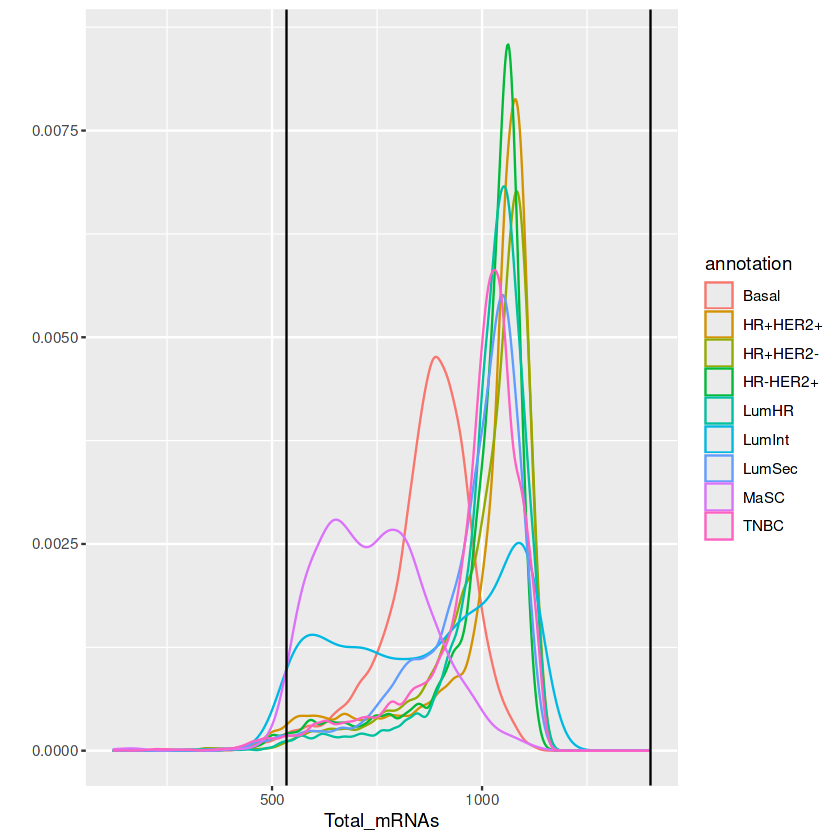

In [24]:
pData(HSMM)$Total_mRNAs <- Matrix::colSums(exprs(HSMM))
HSMM <- HSMM[,pData(HSMM)$Total_mRNAs < 1e6]

upper_bound <- mean(pData(HSMM)$Total_mRNAs) +
            3*sd(pData(HSMM)$Total_mRNAs)
lower_bound <- mean(pData(HSMM)$Total_mRNAs) -
            3*sd(pData(HSMM)$Total_mRNAs)

qplot(Total_mRNAs, data = pData(HSMM), color = annotation, geom =
"density") +
geom_vline(xintercept = lower_bound) +
geom_vline(xintercept = upper_bound)

In [ ]:
diff_test_res <- differentialGeneTest(HSMM[expressed_genes,],
              fullModelFormulaStr = "~annotation", n_cores = 16)
ordering_genes <- row.names (subset(diff_test_res, qval < 0.01))

In [27]:
library(slingshot)

Loading required package: princurve

Loading required package: TrajectoryUtils

